In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

In [3]:
audio_feature = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SWC/audio_feature.csv', sep=',')
audio_feature.drop('Unnamed: 0', axis = 1, inplace = True)
audio_feature.fillna('Instrumental', inplace = True)

In [4]:
music = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SWC/music.csv')
music = music.drop(['Unnamed: 0'], axis = 1)
music = music.dropna(axis = 0)
music = music.reset_index(drop = True)

In [5]:
aa = audio_feature[['song_ids']]
musicp = pd.merge(aa, music)

In [6]:
users = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SWC/user.csv')
users = users.drop(['Unnamed: 0'], axis = 1)

In [7]:
cosine_similarities_w2v = np.load('/content/drive/MyDrive/Colab Notebooks/SWC/similarity_w2v.npy')
cosine_similarities_bert = np.load('/content/drive/MyDrive/Colab Notebooks/SWC/similarity_bert.npy')
cosine_similarities_audio = np.load('/content/drive/MyDrive/Colab Notebooks/SWC/similarity_audio.npy')

## 가사 기반 추천시스템과 오디오 기반 추천시스템 결합



In [8]:
# lyric 5 + audio 5
def lyric_audio_recommendations(index, rec_items):

    # 입력된 인덱스의 음악과 유사한 음악 선정.
    w2v_sim_scores = list(enumerate(cosine_similarities_w2v[index]))
    bert_sim_scores = list(enumerate(cosine_similarities_bert[index]))

    lyric_score = []
    total_score = []

    for i in range(len(w2v_sim_scores)):
      w2v_score = w2v_sim_scores[i][1]
      bert_score = bert_sim_scores[i][1]
      score = w2v_score*0.7+bert_score*0.3
      lyric_score.append((i, score))

    audio_scores = list(enumerate(cosine_similarities_audio[index]))

    for j in range(len(lyric_score)):
      lyric_scores = lyric_score[j][1]
      audio_score = audio_scores[j][1]
      scores = lyric_scores*0.5+audio_score*0.5
      total_score.append((j, scores))

    total_scores = sorted(total_score, key = lambda x: x[1], reverse = True)
    total_scores = total_scores[1:(rec_items+1)]

    # 가장 유사한 음악의 인덱스
    song_indices = [i[0] for i in total_scores]

    return song_indices, total_scores

In [9]:
def print_recommend(index, rec_items, song_indices, sim_scores):
    title = musicp.iloc[index]['song_titles']

    print(f'The {rec_items} recommended songs for {title} are:')
    for i in range(rec_items):
      print(f"Number {i+1}:")
      idx = song_indices[i]
      print(f"{musicp.iloc[idx]['song_titles']} by {musicp.iloc[idx]['artist_names']} with {round(sim_scores[i][1], 3)} similarity score")
      print("----------------------------")

In [10]:
lyric_audio_music_indices, lyric_audio_sim_scores = lyric_audio_recommendations(0, 10)
print_recommend(0, 10, lyric_audio_music_indices, lyric_audio_sim_scores)

The 10 recommended songs for Need are:
Number 1:
Heart Trouble by Martina McBride with 0.955 similarity score
----------------------------
Number 2:
They Say (Album) by Jupiter Rising with 0.955 similarity score
----------------------------
Number 3:
MY HERIONE (Acoustic Version) by Silverstein with 0.94 similarity score
----------------------------
Number 4:
Squarebiz by Galactic with 0.935 similarity score
----------------------------
Number 5:
Career Suicide (CD) by The Cliks with 0.934 similarity score
----------------------------
Number 6:
----------------------------
Number 7:
Don't Let Her Pull You Down by New Found Glory with 0.933 similarity score
----------------------------
Number 8:
The More I See You by Eliane Elias with 0.932 similarity score
----------------------------
Number 9:
Another World (Album Version) by Richard Hell & The Voidoids with 0.931 similarity score
----------------------------
Number 10:
Class Compromise (&History's Glory) by The Business with 0.93 sim

In [13]:
def lyric_audio_recall(num):
  k = len(cosine_similarities_w2v)
  lyric_audio_count_list = []
  for i in range(k):
    rec_indices, rec_sim = lyric_audio_recommendations(i, num)
    rec = []
    for i in range(num):
      rec.append(musicp.iloc[rec_indices[i]]['song_ids'])

    title = musicp['song_ids'].iloc[i]
    title_user = users[users['song_ids'] == title]
    if len(title_user) != 0:
      max_user = title_user['play_count'].idxmax()
      max_user = title_user.loc[max_user]
      max_user_id = max_user['user_id']
      user_0 = users[users['user_id'] == max_user_id]
      user_0 = user_0.sort_values('play_count', ascending = False)
      user_list = list(user_0['song_ids'][:num])
      count = 0
      for i in rec:
        for j in user_list:
          if i == j:
            count += 1
    else:
      count = 0
    lyric_audio_count_list.append(count)

  return sum(lyric_audio_count_list)/k

In [15]:
lyric_audio_recall10 = lyric_audio_recall(10)
print(lyric_audio_recall10)

0.00128739984627614


In [16]:
lyric_audio_recall50 = lyric_audio_recall(50)
print(lyric_audio_recall50)

0.1440183928124286


In [17]:
lyric_audio_dcg_list = []
lyric_audio_idcg_list = []
k = len(cosine_similarities_w2v)
for i in range(k):
  rec_indices, rec_sim = lyric_audio_recommendations(i, 100)
  rec = []
  for i in range(100):
    rec.append(musicp.iloc[rec_indices[i]]['song_ids'])

  title = musicp['song_ids'].iloc[i]
  title_user = users[users['song_ids'] == title]
  if len(title_user) != 0:
    max_user = title_user['play_count'].idxmax()
    max_user = title_user.loc[max_user]
    max_user_id = max_user['user_id']
    user_0 = users[users['user_id'] == max_user_id]
    relevant = []
    for j in range(len(user_0)):
      play = user_0.iloc[j]['play_count']
      if play >= 2 and play <= 5:
        relevant.append(2)
      elif play > 5:
        relevant.append(3)
      elif play < 2:
        relevant.append(1)
    user_0['relevant'] = relevant
    user_0 = user_0.sort_values('play_count', ascending = False)
    user_0 = user_0.reset_index(drop = True)
    user_list = list(user_0['song_ids'])
    dcg_ = 0
    idcg_ = 0
    for k in range(len(user_0)):
      for i in rec:
        for j in user_list:
          if i == j:
            idx = user_0[user_0['song_ids'] == j].index[0]
            dcg_ += (user_0.iloc[idx]['relevant']/np.log2(k+2))
      if k < 100:
        idcg_ += (user_0.iloc[k]['relevant']/np.log2(k+2))
  lyric_audio_dcg_list.append(dcg_)
  lyric_audio_idcg_list.append(idcg_)

lyric_audio_dcg = sum(lyric_audio_dcg_list)/k
lyric_audio_idcg = sum(lyric_audio_idcg_list)/k
ndcg_lyric_audio = lyric_audio_dcg/lyric_audio_idcg
print(ndcg_lyric_audio)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.11684590243681871


In [18]:
# lyric 3 + audio 7
def lyric_audio_recommendations(index, rec_items):

    # 입력된 인덱스의 음악과 유사한 음악 선정.
    w2v_sim_scores = list(enumerate(cosine_similarities_w2v[index]))
    bert_sim_scores = list(enumerate(cosine_similarities_bert[index]))

    lyric_score = []
    total_score = []

    for i in range(len(w2v_sim_scores)):
      w2v_score = w2v_sim_scores[i][1]
      bert_score = bert_sim_scores[i][1]
      score = w2v_score*0.7+bert_score*0.3
      lyric_score.append((i, score))

    audio_scores = list(enumerate(cosine_similarities_audio[index]))

    for j in range(len(lyric_score)):
      lyric_scores = lyric_score[j][1]
      audio_score = audio_scores[j][1]
      scores = lyric_scores*0.3+audio_score*0.7
      total_score.append((j, scores))

    total_scores = sorted(total_score, key = lambda x: x[1], reverse = True)
    total_scores = total_scores[1:(rec_items+1)]

    # 가장 유사한 음악의 인덱스
    song_indices = [i[0] for i in total_scores]

    return song_indices, total_scores

In [19]:
lyric_audio_music_indices73, lyric_audio_sim_scores73 = lyric_audio_recommendations(0, 10)
print_recommend(0, 10, lyric_audio_music_indices73, lyric_audio_sim_scores73)

The 10 recommended songs for Need are:
Number 1:
They Say (Album) by Jupiter Rising with 0.972 similarity score
----------------------------
Number 2:
Heart Trouble by Martina McBride with 0.971 similarity score
----------------------------
Number 3:
MY HERIONE (Acoustic Version) by Silverstein with 0.962 similarity score
----------------------------
Number 4:
Squarebiz by Galactic with 0.96 similarity score
----------------------------
Number 5:
The More I See You by Eliane Elias with 0.959 similarity score
----------------------------
Number 6:
Another World (Album Version) by Richard Hell & The Voidoids with 0.958 similarity score
----------------------------
Number 7:
Class Compromise (&History's Glory) by The Business with 0.957 similarity score
----------------------------
Number 8:
Don't Let Her Pull You Down by New Found Glory with 0.957 similarity score
----------------------------
Number 9:
Career Suicide (CD) by The Cliks with 0.955 similarity score
-------------------------

In [20]:
lyric_audio73_recall10 = lyric_audio_recall(10)
print(lyric_audio73_recall10)

0.00264938625401075


In [21]:
lyric_audio73_recall50 = lyric_audio_recall(50)
print(lyric_audio73_recall50)

0.1433496529863048


In [22]:
lyric_audio_dcg_list = []
lyric_audio_idcg_list = []
k = len(cosine_similarities_w2v)
for i in range(k):
  rec_indices, rec_sim = lyric_audio_recommendations(i, 100)
  rec = []
  for i in range(100):
    rec.append(musicp.iloc[rec_indices[i]]['song_ids'])

  title = musicp['song_ids'].iloc[i]
  title_user = users[users['song_ids'] == title]
  if len(title_user) != 0:
    max_user = title_user['play_count'].idxmax()
    max_user = title_user.loc[max_user]
    max_user_id = max_user['user_id']
    user_0 = users[users['user_id'] == max_user_id]
    relevant = []
    for j in range(len(user_0)):
      play = user_0.iloc[j]['play_count']
      if play >= 2 and play <= 5:
        relevant.append(2)
      elif play > 5:
        relevant.append(3)
      elif play < 2:
        relevant.append(1)
    user_0['relevant'] = relevant
    user_0 = user_0.sort_values('play_count', ascending = False)
    user_0 = user_0.reset_index(drop = True)
    user_list = list(user_0['song_ids'])
    dcg_ = 0
    idcg_ = 0
    for k in range(len(user_0)):
      for i in rec:
        for j in user_list:
          if i == j:
            idx = user_0[user_0['song_ids'] == j].index[0]
            dcg_ += (user_0.iloc[idx]['relevant']/np.log2(k+2))
      if k < 100:
        idcg_ += (user_0.iloc[k]['relevant']/np.log2(k+2))
  lyric_audio_dcg_list.append(dcg_)
  lyric_audio_idcg_list.append(idcg_)

lyric_audio_dcg = sum(lyric_audio_dcg_list)/k
lyric_audio_idcg = sum(lyric_audio_idcg_list)/k
ndcg_lyric_audio73 = lyric_audio_dcg/lyric_audio_idcg
print(ndcg_lyric_audio73)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.08937482622015128


In [23]:
# lyric 2 + audio 8
def lyric_audio_recommendations(index, rec_items):

    # 입력된 인덱스의 음악과 유사한 음악 선정.
    w2v_sim_scores = list(enumerate(cosine_similarities_w2v[index]))
    bert_sim_scores = list(enumerate(cosine_similarities_bert[index]))

    lyric_score = []
    total_score = []

    for i in range(len(w2v_sim_scores)):
      w2v_score = w2v_sim_scores[i][1]
      bert_score = bert_sim_scores[i][1]
      score = w2v_score*0.7+bert_score*0.3
      lyric_score.append((i, score))

    audio_scores = list(enumerate(cosine_similarities_audio[index]))

    for j in range(len(lyric_score)):
      lyric_scores = lyric_score[j][1]
      audio_score = audio_scores[j][1]
      scores = lyric_scores*0.2+audio_score*0.8
      total_score.append((j, scores))

    total_scores = sorted(total_score, key = lambda x: x[1], reverse = True)
    total_scores = total_scores[1:(rec_items+1)]

    # 가장 유사한 음악의 인덱스
    song_indices = [k[0] for k in total_scores]

    return song_indices, total_scores

In [24]:
lyric_audio_music_indices, lyric_audio_sim_scores = lyric_audio_recommendations(0, 10)
print_recommend(0, 10, lyric_audio_music_indices, lyric_audio_sim_scores)

The 10 recommended songs for Need are:
Number 1:
They Say (Album) by Jupiter Rising with 0.981 similarity score
----------------------------
Number 2:
Heart Trouble by Martina McBride with 0.979 similarity score
----------------------------
Number 3:
MY HERIONE (Acoustic Version) by Silverstein with 0.973 similarity score
----------------------------
Number 4:
The More I See You by Eliane Elias with 0.972 similarity score
----------------------------
Number 5:
Squarebiz by Galactic with 0.972 similarity score
----------------------------
Number 6:
Another World (Album Version) by Richard Hell & The Voidoids with 0.971 similarity score
----------------------------
Number 7:
Class Compromise (&History's Glory) by The Business with 0.971 similarity score
----------------------------
Number 8:
Don't Let Her Pull You Down by New Found Glory with 0.969 similarity score
----------------------------
Number 9:
I WANNA HEAR IT FROM YOU by Eddy Raven with 0.969 similarity score
------------------

In [25]:
lyric_audio82_recall10 = lyric_audio_recall(10)
print(lyric_audio82_recall10)

0.00302273984781907


In [27]:
lyric_audio82_recall50 = lyric_audio_recall(50)
print(lyric_audio82_recall50)

0.15145273152062982


In [28]:
lyric_audio_dcg_list = []
lyric_audio_idcg_list = []
k = len(cosine_similarities_w2v)
for i in range(k):
  rec_indices, rec_sim = lyric_audio_recommendations(i, 100)
  rec = []
  for i in range(100):
    rec.append(musicp.iloc[rec_indices[i]]['song_ids'])

  title = musicp['song_ids'].iloc[i]
  title_user = users[users['song_ids'] == title]
  if len(title_user) != 0:
    max_user = title_user['play_count'].idxmax()
    max_user = title_user.loc[max_user]
    max_user_id = max_user['user_id']
    user_0 = users[users['user_id'] == max_user_id]
    relevant = []
    for j in range(len(user_0)):
      play = user_0.iloc[j]['play_count']
      if play >= 2 and play <= 5:
        relevant.append(2)
      elif play > 5:
        relevant.append(3)
      elif play < 2:
        relevant.append(1)
    user_0['relevant'] = relevant
    user_0 = user_0.sort_values('play_count', ascending = False)
    user_0 = user_0.reset_index(drop = True)
    user_list = list(user_0['song_ids'])
    dcg_ = 0
    idcg_ = 0
    for k in range(len(user_0)):
      for i in rec:
        for j in user_list:
          if i == j:
            idx = user_0[user_0['song_ids'] == j].index[0]
            dcg_ += (user_0.iloc[idx]['relevant']/np.log2(k+2))
      if k < 100:
        idcg_ += (user_0.iloc[k]['relevant']/np.log2(k+2))
  lyric_audio_dcg_list.append(dcg_)
  lyric_audio_idcg_list.append(idcg_)

lyric_audio_dcg = sum(lyric_audio_dcg_list)/k
lyric_audio_idcg = sum(lyric_audio_idcg_list)/k
ndcg_lyric_audio82 = lyric_audio_dcg/lyric_audio_idcg
print(ndcg_lyric_audio82)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.09304925381045286


In [29]:
import seaborn as sns

data = {'recall@10' : [lyric_audio_recall10, lyric_audio73_recall10, lyric_audio82_recall10],
        'recall@50' : [lyric_audio_recall50, lyric_audio73_recall50, lyric_audio82_recall50],
        'nDCG_100' : [ndcg_lyric_audio, ndcg_lyric_audio73, ndcg_lyric_audio82]}

result = pd.DataFrame(data)
result.index = ['lyr5+aud5', 'lyr3+aud7', 'lyr2+aud8']

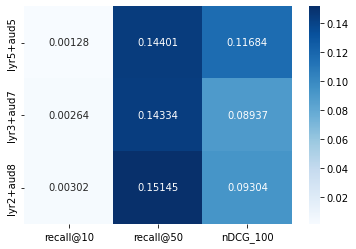

In [30]:
re_heat = sns.heatmap(result, annot = True, fmt = '.5f', cmap = 'Blues')